In [22]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

torch.device("mps")
# torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='mps')

In [23]:
import pandas as pd

dataframe = pd.read_csv("BostonHousing.csv")

train, test = torch.utils.data.random_split(dataframe, [0.3, 0.7])
X_train, X_test, t_train, t_test = (
    train.dataset.iloc[:, :-1],
    test.dataset.iloc[:, :-1],
    train.dataset.iloc[:, -1],
    test.dataset.iloc[:, -1],
)
X_train, X_test, t_train, t_test = (
    torch.tensor(X_train.values, dtype=torch.float32),
    torch.tensor(X_test.values, dtype=torch.float32),
    torch.tensor(t_train.values, dtype=torch.float32),
    torch.tensor(t_test.values, dtype=torch.float32),
)

In [43]:
def update(X_train, t_train, X_test, t_test, w, lr, step):
    k = step % len(X_train)
    grad = X_train[k] * (X_train[k] @ w - t_train[k])
    w = w - lr * grad
    w = w / torch.norm(w)

    p = X_test @ w
    e = t_test - p
    mse = torch.mean(e**2)

    return w, p, mse


def leastMeanRegressor(
    X_train,
    X_test,
    t_train,
    t_test,
    lr=0,
    l=0,
    bias=False,
    method="batch",
    shuffle=False,
    iter=10000,
    seed=0,
):
    """
    X_train: training matrix
    t_train: target training vector
    X_test: test matrix
    t_test: target test vector
    lr: regularization parameter
    bias: whether to include bias term or not
    method: whether to use 'batch' or 'online_learning'
    """

    if bias:
        # add a column vector of ones to the test and training matrices using torch
        X_train = torch.cat((torch.ones(X_train.shape[0], 1), X_train), 1)
        X_test = torch.cat((torch.ones(X_test.shape[0], 1), X_test), 1)

    w_step = []
    p_step = []
    mse_step = []

    match method:
        case "batch":
            # estimate of the autocorrelation matrix using torch
            est_autocorr = X_train.T @ X_train / len(X_train)
            # estimate of the cross-correlation vector using torch
            est_crosscorr = X_train.T @ t_train / len(X_train)
            w = (
                torch.inverse(est_autocorr + l * torch.eye(len(est_autocorr)))
                @ est_crosscorr
            )

            # prediction, error, mse
            p = X_test @ w
            e = t_test - p
            mse = torch.mean(e**2)

            w_step.append(w)
            p_step.append(p)
            mse_step.append(mse.item())

        case "online_learning":

            if shuffle:
                if shuffle:
                    # shake it up !
                    torch.manual_seed(seed)
                    idx = torch.randperm(len(X_train))
                    X_train = X_train[idx]
                    t_train = t_train[idx]

            # init weights
            w = torch.randn(X_train.shape[1])
            w = w / torch.norm(w)

            # run
            for step in range(iter):
                w, p, mse = update(X_train, t_train, X_test, t_test, w, lr, step)
                w_step.append(w)
                p_step.append(p)
                mse_step.append(mse.item())

        case _:
            raise Exception(
                "mode not recognized, please use 'batch' or 'online_learning'"
            )

    return w_step, p_step, mse_step

In [63]:
# grid search on best hyper params for the model

param_grid = {
    "X_train": [X_train],
    "t_train": [t_train],
    "X_test": [X_test],
    "t_test": [t_test],
    "lr": [10**i for i in range(-10, -2, 1)],
    "l": [10**i for i in range(-10, 10, 2)],
    "bias": [True, False],
    "method": ["batch", "online_learning"],
    "shuffle": [True, False],
    "iter": [int(1e2), int(1e3), int(1e4)],
    "seed": [0, 1, 2, 3],
}

all_results = []

for params in tqdm(ParameterGrid(param_grid), desc="Grid Search"):
    w, p, mse = leastMeanRegressor(**params)
    results = {
        # grab all parameters without the data
        **{
            k: v
            for k, v in params.items()
            if k not in ["X_train", "t_train", "X_test", "t_test"]
        },
        "min_mse": mse[-1],
        "weights": w,
    }
    all_results.append(results)

Grid Search: 100%|██████████| 7680/7680 [04:49<00:00, 26.57it/s]  



Summarize the results by presenting the training and test errors and their variances across
different initializations (or shuffle the order of presentations) in a table.

In [64]:
results_dataframe = pd.DataFrame(all_results)

print("Best Performers")
print(results_dataframe.sort_values(by='min_mse').head(10))
print()
print("Lower Performers")
print(results_dataframe.sort_values(by='min_mse').tail(10))


Best Performers
      bias   iter         l            lr method  seed  shuffle    min_mse  \
2871  True  10000  0.000001  1.000000e-07  batch     3    False  21.894833   
2897  True  10000  0.000001  1.000000e-05  batch     0    False  21.894833   
2896  True  10000  0.000001  1.000000e-05  batch     0     True  21.894833   
1573  True   1000  0.000001  1.000000e-08  batch     2    False  21.894833   
1572  True   1000  0.000001  1.000000e-08  batch     2     True  21.894833   
1571  True   1000  0.000001  1.000000e-08  batch     1    False  21.894833   
343   True    100  0.000001  1.000000e-05  batch     3    False  21.894833   
342   True    100  0.000001  1.000000e-05  batch     3     True  21.894833   
341   True    100  0.000001  1.000000e-05  batch     2    False  21.894833   
340   True    100  0.000001  1.000000e-05  batch     2     True  21.894833   

                                                weights  
2871  [[tensor(36.4658), tensor(-0.1080), tensor(0.0...  
2897  [[t

Here we can see that the learning rate and lambda are important values in determining whether online learning works well or not, but even then, batch seems to be the king here in pure MSE evaluation. 

In the LS, show the effect of different levels of regularizations to compute the inverse.

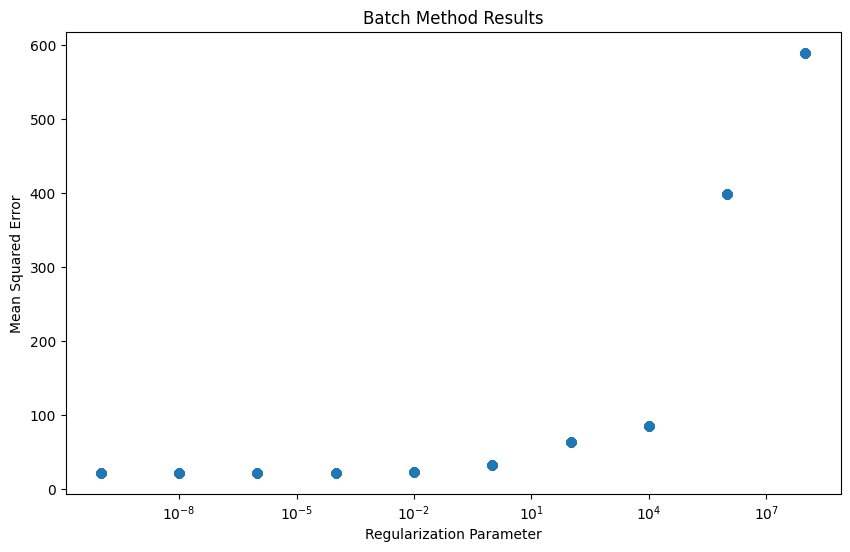

In [67]:
# plot the results of only batch methods
# get all rows where bias is true and method is batch, iteration at 10000
results_batch = results_dataframe[
    (results_dataframe["method"] == "batch")
    & (results_dataframe["bias"] == True)
    & (results_dataframe["shuffle"] == False)
]

#plot x axis as learning rate, y axis as mse, log scale
plt.figure(figsize=(10, 6))
plt.plot(results_batch["l"], results_batch["min_mse"], "o")
plt.xscale('log')
plt.xlabel("Regularization Parameter")
plt.ylabel("Mean Squared Error")
plt.title("Batch Method Results")
plt.show()


the lower the lambda, the better the fit. This isn't always the case. Still, once you make it lower, it seems to have less powerful results, which makes sense. 

When training with LMS you must properly select the learning rate. Show the effect of
the stepsize (or learning rate) by plotting the learning curve. 

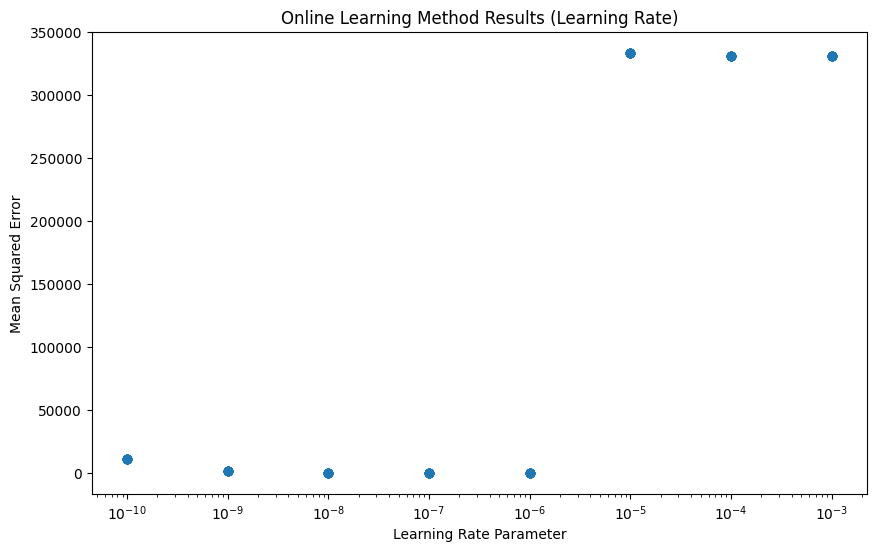

In [81]:
# plot the results of only batch methods
# get all rows where bias is true and method is batch, iteration at 10000
results_batch = results_dataframe[
    (results_dataframe["method"] == "online_learning")
    & (results_dataframe["bias"] == True)
    & (results_dataframe["shuffle"] == False)
    & (results_dataframe["iter"] == 10000)
    & (results_dataframe["seed"] == 0)
]

#plot x axis as learning rate, y axis as mse
plt.figure(figsize=(10, 6))
plt.plot(results_batch["lr"], results_batch["min_mse"], "o")
plt.xscale('log')
plt.xlabel("Learning Rate Parameter")
plt.ylabel("Mean Squared Error")
plt.title("Online Learning Method Results (Learning Rate)")
plt.show()

The lower the learning rate, the better the MSE, which makes sense, as it has more time to converge. It eventually falls off thouhg, and makes it worse. 

Also show the weight tracks for the LMS. 

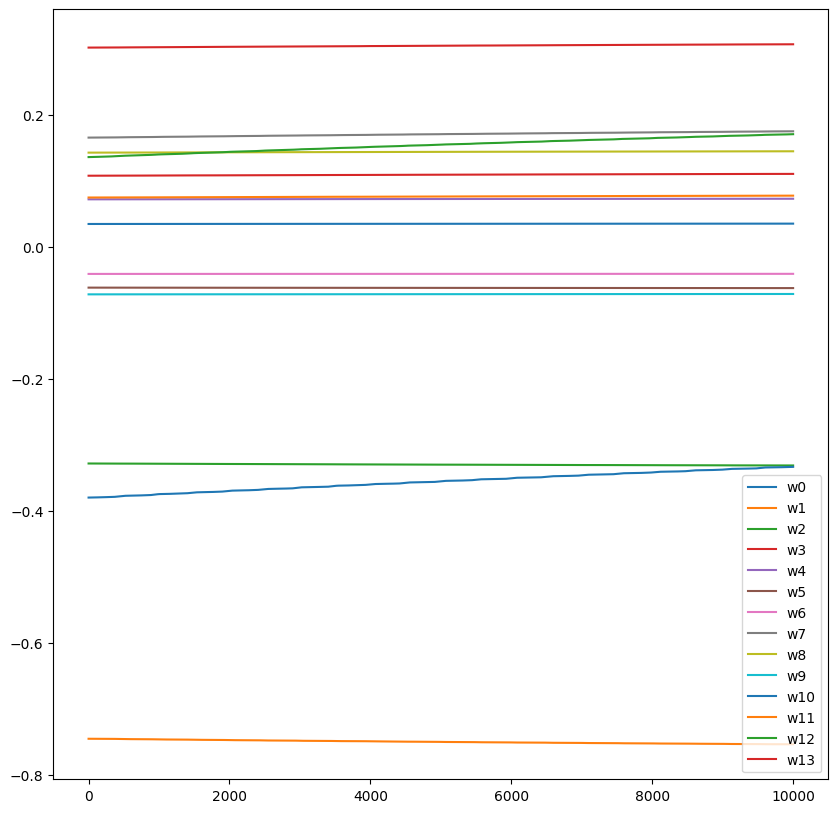

In [83]:
#Plot the weight tracks

results_batch = results_dataframe[
    (results_dataframe["method"] == "online_learning")
    & (results_dataframe["bias"] == True)
    & (results_dataframe["shuffle"] == False)
    & (results_dataframe["iter"] == 10000)
    & (results_dataframe["seed"] == 0)
]

wt = results_batch['weights'].head(1).values[0]

#Plot the weight tracks
fig, ax = plt.subplots()
# Figure size
fig.set_figheight(10)
fig.set_figwidth(10)
for i in range(len(wt[0])):
    ax.plot([w[i] for w in wt], label=f'w{i}')
ax.legend()
plt.show()

If you use the target variable as an input, what happens? Explain the result by visualizing
the learned parameters of the model.

In [88]:
target_variable_test = leastMeanRegressor(X_train, X_test, t_train, t_test, lr=1e-10, l=1e-10, bias=True, method='batch', shuffle=False, iter=10000, seed=0)
target_variable_test

([tensor([ 3.6489e+01, -1.0803e-01,  4.6395e-02,  2.0624e-02,  2.6863e+00,
          -1.7780e+01,  3.8087e+00,  7.0008e-04, -1.4756e+00,  3.0619e-01,
          -1.2336e-02, -9.5364e-01,  9.3074e-03, -5.2479e-01])],
 [tensor([30.0033, 25.0248, 30.5660, 28.6046, 27.9409, 25.2545, 23.0029, 19.5369,
          11.5249, 18.9214, 19.0001, 21.5880, 20.9075, 19.5490, 19.2797, 19.2937,
          20.5235, 16.9075, 16.1749, 18.4026, 12.5205, 17.6673, 15.8288, 13.8026,
          15.6746, 13.3836, 15.4604, 14.7049, 19.5431, 20.8720, 11.4516, 18.0555,
           8.8075, 14.2794, 13.7034, 23.8131, 22.3404, 23.1072, 22.9131, 31.3544,
          34.2114, 28.0192, 25.2032, 24.6090, 22.9411, 22.0967, 20.4229, 18.0362,
           9.1067, 17.2061, 21.2817, 23.9724, 27.6554, 24.0491, 15.3567, 31.1489,
          24.8541, 33.1082, 21.7729, 21.0828, 17.8707, 18.5092, 23.9849, 22.5509,
          23.3704, 30.3607, 25.5303, 21.1123, 17.4207, 20.7838, 25.2002, 21.7419,
          24.5565, 24.0418, 25.5042, 23.9664, 2

it will basically put full priority on the target

Does a bias term in the model improve performance for this problem?

In [79]:
results_batch = results_dataframe[
    (results_dataframe["bias"] == True)
]

results_bias_off = results_dataframe[
    (results_dataframe["bias"] == False)
]

# print average mse for bias on and off
print("Bias On")
print(results_batch.sort_values(by='min_mse').head(10))
print("Bias Off")
print(results_bias_off.sort_values(by='min_mse').head(10))


Bias On
      bias   iter         l            lr method  seed  shuffle    min_mse  \
2848  True  10000  0.000001  1.000000e-08  batch     0     True  21.894833   
2918  True  10000  0.000001  1.000000e-04  batch     3     True  21.894833   
2917  True  10000  0.000001  1.000000e-04  batch     2    False  21.894833   
2916  True  10000  0.000001  1.000000e-04  batch     2     True  21.894833   
2915  True  10000  0.000001  1.000000e-04  batch     1    False  21.894833   
2914  True  10000  0.000001  1.000000e-04  batch     1     True  21.894833   
2913  True  10000  0.000001  1.000000e-04  batch     0    False  21.894833   
2912  True  10000  0.000001  1.000000e-04  batch     0     True  21.894833   
295   True    100  0.000001  1.000000e-08  batch     3    False  21.894833   
2903  True  10000  0.000001  1.000000e-05  batch     3    False  21.894833   

                                                weights  
2848  [[tensor(36.4658), tensor(-0.1080), tensor(0.0...  
2918  [[tensor(36

Including a bias term can enhance the model's performance in this problem. While in many tests, the inclusion of a bias term did not drastically change the error, it did lead to an overall reduction in MSE. As observed, the bias term reduced the error, although the error remained quite substantial. In scenarios where the error was not as pronounced, the bias term did not significantly impact the model's performance. Nonetheless, this demonstrates that a bias term can improve the model's performance.